In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, auc, precision_recall_curve, f1_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline

In [44]:
## Spilts stratified on classes in case of single output but not possible in multioutput
def split_data(X, y):
    if len(y.shape) == 1:
        return train_test_split(X, y, stratify = y, test_size=0.33, random_state=42)
    else:
        return train_test_split(X, y, test_size=0.33, random_state=42)

def performance(y_test, y_pred, y_pred_prob):

    confusion_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['True_0', 'True_1'], 
                                 columns=['Predicted_0', 'Predicted_1'])
    # AUPRC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:,1])
    auprc = auc(recall, precision)
    print("AUPRC score: {:.4f}".format(auprc))
    # AUROC
    auroc = roc_auc_score(y_test, y_pred_prob[:, 1])
    print("AUROC score: {:.4f}".format(auroc))
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy Score: {:.4f}".format(acc))
    return confusion_mat

In [3]:
def model_fitting_bin(X, y, estimator, params = {}, score = 'roc_auc', results = True):
    X_train, X_test, y_train, y_test = split_data(X, y)
    
    pipe = Pipeline([('scale', StandardScaler()), ('model', estimator)])
    
    clf = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, scoring=score)
    clf.fit(X_train, y_train)
    best_parameters = clf.best_params_
    
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    
    if results:
        return performance(y_test, y_pred, y_pred_prob)
    else:
        return best_parameters, y_test, y_pred, y_pred_prob

In [27]:
def model_fitting_multi(X, y, estimator, params = {}, score = 'roc_auc'):
    X_train, X_test, y_train, y_test = split_data(X, y)
    
    pipe = Pipeline([('scale', StandardScaler()), ('model', estimator)])
    
    clf = GridSearchCV(pipe, params, cv = 5, n_jobs=-1, scoring=score)
    clf.fit(X_train, y_train)
    
    return clf

# TCGA Data

## Predicting Tissue type from gene expression values

In [2]:
tcga = pd.read_csv('data/TCGA_Expr_GOI.csv')
tcga.head()

,Study_Abbr,Tissue_Type,TCGA_ID,Is_Normal,ENSG00000107796,ENSG00000119844,ENSG00000168283,ENSG00000039068,ENSG00000140937,ENSG00000170558,...,ENSG00000006327,ENSG00000140416,ENSG00000198467,ENSG00000167460,ENSG00000162692,ENSG00000038427,ENSG00000112715,ENSG00000150630,ENSG00000115935,ENSG00000114251
0,ACC,E,TCGA-OR-A5JI-01A-11R-A29S-07,False,27746.468600,9868.619112,22104.78289,46.195994,9683.835138,6207.586627,...,137086.610700,20638.06010,13183.181650,216191.47510,24351.063080,48228.617220,24495.42555,4186.511911,22133.655390,3054.710070
1,ACC,E,TCGA-OR-A5J2-01A-11R-A29S-07,False,17327.168710,11220.148390,66218.65916,183.705200,2842.720216,445.131832,...,10120.272390,12239.94778,20746.911670,65074.03445,79645.625150,58495.975160,105715.27720,1983.074086,7520.137242,8050.056089
2,ACC,E,TCGA-OR-A5K0-01A-11R-A29S-07,False,15592.579790,16432.595450,25723.37103,13.494227,121.448047,136649.294000,...,19954.588800,15440.76973,5222.266013,36778.51684,198317.913300,4537.433971,81683.93215,182.172070,3444.401550,13.494227
3,ACC,E,TCGA-OR-A5KU-01A-11R-A29S-07,False,8991.353206,9624.877571,11398.74579,4.692773,25908.800130,53028.335720,...,34965.852160,18358.12826,5908.201298,76266.94797,33337.459910,88242.904850,135879.24430,140.783192,5119.815422,3388.182158
4,ACC,E,TCGA-OR-A5LO-01A-11R-A29S-07,False,45962.179440,13845.513050,24423.08642,11.723550,83876.141520,753.238115,...,8241.655949,15217.16845,20703.790050,55642.90121,527.559769,9287.982825,84374.39242,586.177521,2925.025831,1732.154575


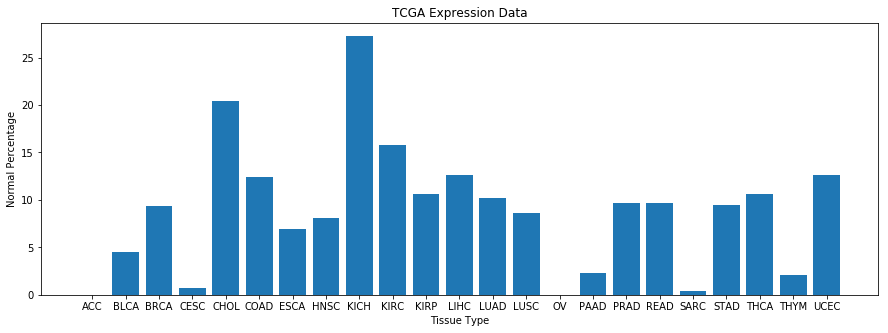

In [39]:
tissue_count = tcga.pivot_table(columns='Study_Abbr', values='Is_Normal', aggfunc='count')
tissue_normal = tcga.pivot_table(columns='Study_Abbr', values='Is_Normal', aggfunc= lambda x: sum(x))

percent_normal = tissue_normal.values.flatten()/tissue_count.values.flatten()*100.0

figure(figsize=(15, 5))
plt.bar(x = tissue_count.columns, height =  percent_normal)
plt.xlabel("Tissue Type")
plt.ylabel("Normal Percentage")
plt.title("TCGA Expression Data")
plt.show()

In [13]:
# Encoding E as 1 and M as 0
y = np.where(tcga["Tissue_Type"].str.contains("E"), 1, 0)
X = tcga.drop(columns = ["Study_Abbr", "Tissue_Type", "TCGA_ID", "Is_Normal"]).values

In [14]:
params = {'model__penalty' : ['l1', 'l2'],
          'model__C' : [0.1, 1.0, 5.0],
         }
model_fitting_bin(X, y, LogisticRegression(class_weight = 'balanced'), params= params )

AUPRC score: 0.9993
AUROC score: 0.9888
Accuracy Score: 0.9906


,Predicted_0,Predicted_1
True_0,79,7
True_1,17,2456


### Predicting on GTEx

In [4]:
Gtex = pd.read_csv('data/GTEx_Expr_GOI.csv')
Gtex.head()

,Study_Abbr,Tissue_Type,TCGA_ID,Is_Normal,ENSG00000107796,ENSG00000119844,ENSG00000168283,ENSG00000039068,ENSG00000140937,ENSG00000170558,...,ENSG00000006327,ENSG00000140416,ENSG00000198467,ENSG00000167460,ENSG00000162692,ENSG00000038427,ENSG00000112715,ENSG00000150630,ENSG00000115935,ENSG00000114251
0,Adipose Tissue,M,SRR615237,True,76704.58000,8826.62100,8640.143000,227.917400,5946.573000,331.516300,...,2817.888000,94937.9700,81180.0500,121293.5000,2735.009000,38663.08000,107017.60000,1864.779000,18109.08000,310.796500
1,Adipose Tissue,M,SRR658081,True,837359.43830,11040.63138,10834.676900,353.064828,22890.369660,294.220690,...,3251.138621,230411.5776,221143.6259,224181.4545,8782.487586,63948.86690,33408.75931,6333.100345,25884.06517,316.287241
2,Adipose Tissue,M,SRR1090407,True,68842.49603,11080.92886,9164.869237,135.650239,6146.651431,101.737679,...,1322.589825,102475.2770,64374.5163,107740.2019,11445.488870,31759.11208,81212.10215,8588.355723,21576.86606,584.991653
3,Adipose Tissue,M,SRR813680,True,170189.04190,10835.63101,9891.337950,121.333746,8387.854581,100.232225,...,759.654754,112734.8757,105723.8954,101445.5620,2954.212934,29473.54940,54431.37332,6662.805243,19070.49957,316.522814
4,Adipose Tissue,M,SRR662103,True,666778.70090,12931.14812,15304.684250,816.866330,7690.873555,909.341763,...,2666.375000,287305.7594,357540.8512,208902.0043,3036.276734,38593.08092,78311.27962,4300.107659,18448.84899,107.888006


In [12]:
# Removing samples for which Tissue Type is unknown
filter_out = np.where(Gtex["Tissue_Type"].values != "E/M")
Gtex_filter = Gtex.iloc[filter_out]
# Encoding E as 1 and M as 0
y_gtex = np.where(Gtex_filter["Tissue_Type"].str.contains("E"), 1, 0)
# Dropping "Is_Normal" since all the samples are normal
X_gtex = Gtex_filter.drop(columns = ["Study_Abbr", "Tissue_Type", "TCGA_ID", "Is_Normal"]).values
y_gtex_pred = clf.predict(X_gtex)
y_gtex_pred_prob = clf.predict_proba(X_gtex)

In [11]:
confusion_matrix(y_gtex, y_gtex_pred)

array([[298, 674],
       [  0, 532]], dtype=int64)

In [13]:
# AUPRC
precision, recall, _ = precision_recall_curve(y_gtex, y_gtex_pred_prob[:,1])
auprc = auc(recall, precision)
print(auprc)

0.7205638474295191


## Predicting both tissue types and normality on TCGA data

Casting it as a multiclass problem

In [19]:
data = pd.read_csv('data/TCGA_Expr_GOI.csv')

data["Type_Normal"] = data["Tissue_Type"].astype('str') + '_' + data["Is_Normal"].astype('str')

In [26]:
data.head()

,Study_Abbr,Tissue_Type,TCGA_ID,Is_Normal,ENSG00000107796,ENSG00000119844,ENSG00000168283,ENSG00000039068,ENSG00000140937,ENSG00000170558,...,ENSG00000140416,ENSG00000198467,ENSG00000167460,ENSG00000162692,ENSG00000038427,ENSG00000112715,ENSG00000150630,ENSG00000115935,ENSG00000114251,Type_Normal
0,ACC,E,TCGA-OR-A5JI-01A-11R-A29S-07,False,27746.468600,9868.619112,22104.78289,46.195994,9683.835138,6207.586627,...,20638.06010,13183.181650,216191.47510,24351.063080,48228.617220,24495.42555,4186.511911,22133.655390,3054.710070,E_False
1,ACC,E,TCGA-OR-A5J2-01A-11R-A29S-07,False,17327.168710,11220.148390,66218.65916,183.705200,2842.720216,445.131832,...,12239.94778,20746.911670,65074.03445,79645.625150,58495.975160,105715.27720,1983.074086,7520.137242,8050.056089,E_False
2,ACC,E,TCGA-OR-A5K0-01A-11R-A29S-07,False,15592.579790,16432.595450,25723.37103,13.494227,121.448047,136649.294000,...,15440.76973,5222.266013,36778.51684,198317.913300,4537.433971,81683.93215,182.172070,3444.401550,13.494227,E_False
3,ACC,E,TCGA-OR-A5KU-01A-11R-A29S-07,False,8991.353206,9624.877571,11398.74579,4.692773,25908.800130,53028.335720,...,18358.12826,5908.201298,76266.94797,33337.459910,88242.904850,135879.24430,140.783192,5119.815422,3388.182158,E_False
4,ACC,E,TCGA-OR-A5LO-01A-11R-A29S-07,False,45962.179440,13845.513050,24423.08642,11.723550,83876.141520,753.238115,...,15217.16845,20703.790050,55642.90121,527.559769,9287.982825,84374.39242,586.177521,2925.025831,1732.154575,E_False


In [28]:
np.unique(data["Type_Normal"].values)

array(['E_False', 'E_True', 'M_False', 'M_True'], dtype=object)

In [53]:
pd.crosstab(index = data["Type_Normal"], columns="count" )

col_0,count
Type_Normal,
E_False,6827
E_True,689
M_False,236
M_True,1


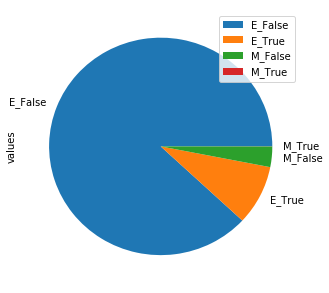

In [20]:
tissues = data["Type_Normal"].value_counts()
df = pd.DataFrame({'labels': tissues.index,
                  'values':tissues.values}, index = np.unique(data["Type_Normal"].values))
df.plot.pie(y= 'values', figsize = (5,5))

In [21]:
data["Type_Normal"] = data["Type_Normal"].astype('category').cat.codes

In [22]:
y = data["Type_Normal"].values
X = data.drop(columns = ["Study_Abbr", "Tissue_Type", "TCGA_ID", "Is_Normal", "Type_Normal"]).values

In [ ]:
X_train, X_test, y_train, y_test = split_data(X, y)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

### XGBoost

In [47]:
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class = 4)

params = {'max_depth':  [7, 8, 9],
          'learning_rate' : [0.01, 0.1, 0.2],
          'n_estimators' : [ 300, 500, 700],
          #'min_child_weight': [5, 11, 15]
            
}

clf = GridSearchCV(xgb_model, params, n_jobs=-1, 
                   cv= 5, 
                   scoring='f1_micro',
                   verbose=2, refit=True)
clf.fit(X_train, y_train)
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])

y_pred = clf.predict(X_test)
# y_pred_prob = clf.predict_proba(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=50)]: Done 104 out of 135 | elapsed: 56.0min remaining: 16.7min
[Parallel(n_jobs=50)]: Done 135 out of 135 | elapsed: 58.8min finished
C:\APPS\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\APPS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [48]:
confusion_matrix(y_test, y_pred)

array([[2225,   11,    3,    0],
       [  36,  198,    0,    0],
       [   4,    0,   81,    0],
       [   0,    1,    0,    0]], dtype=int64)

In [55]:
accuracy_score(y_test, y_pred)

0.978507229386479

### Multioutput Classifier over XGB

In [3]:
data.head()

,Study_Abbr,Tissue_Type,TCGA_ID,Is_Normal,ENSG00000107796,ENSG00000119844,ENSG00000168283,ENSG00000039068,ENSG00000140937,ENSG00000170558,...,ENSG00000140416,ENSG00000198467,ENSG00000167460,ENSG00000162692,ENSG00000038427,ENSG00000112715,ENSG00000150630,ENSG00000115935,ENSG00000114251,Type_Normal
0,ACC,E,TCGA-OR-A5JI-01A-11R-A29S-07,False,27746.468600,9868.619112,22104.78289,46.195994,9683.835138,6207.586627,...,20638.06010,13183.181650,216191.47510,24351.063080,48228.617220,24495.42555,4186.511911,22133.655390,3054.710070,E_False
1,ACC,E,TCGA-OR-A5J2-01A-11R-A29S-07,False,17327.168710,11220.148390,66218.65916,183.705200,2842.720216,445.131832,...,12239.94778,20746.911670,65074.03445,79645.625150,58495.975160,105715.27720,1983.074086,7520.137242,8050.056089,E_False
2,ACC,E,TCGA-OR-A5K0-01A-11R-A29S-07,False,15592.579790,16432.595450,25723.37103,13.494227,121.448047,136649.294000,...,15440.76973,5222.266013,36778.51684,198317.913300,4537.433971,81683.93215,182.172070,3444.401550,13.494227,E_False
3,ACC,E,TCGA-OR-A5KU-01A-11R-A29S-07,False,8991.353206,9624.877571,11398.74579,4.692773,25908.800130,53028.335720,...,18358.12826,5908.201298,76266.94797,33337.459910,88242.904850,135879.24430,140.783192,5119.815422,3388.182158,E_False
4,ACC,E,TCGA-OR-A5LO-01A-11R-A29S-07,False,45962.179440,13845.513050,24423.08642,11.723550,83876.141520,753.238115,...,15217.16845,20703.790050,55642.90121,527.559769,9287.982825,84374.39242,586.177521,2925.025831,1732.154575,E_False


In [25]:
data["Tissue_Type"] = data["Tissue_Type"].astype('category').cat.codes

y = np.asarray(list(zip(data["Tissue_Type"], data["Is_Normal"])))
X = data.drop(columns = ["Study_Abbr", "Tissue_Type", "TCGA_ID", "Is_Normal", "Type_Normal"]).values

In [29]:
params = {'model__estimator__max_depth':  [4,5,6],
          'model__estimator__learning_rate' : [0.01, 0.1, 0.2],
          'model__estimator__n_estimators' : [300, 500, 700]
}
model = MultiOutputClassifier(xgb.XGBClassifier(), n_jobs=-1)

clf = model_fitting_multi(X, y, model, params = params, score = 'f1_micro')

In [31]:
X_train, X_test, y_train, y_test = split_data(X, y)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average='micro')

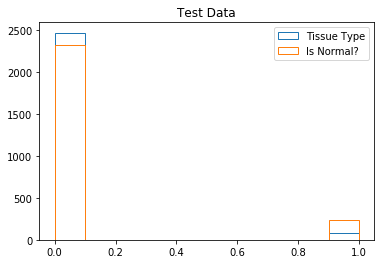

In [32]:
plt.hist(y_test[:, 0], histtype='step', label = 'Tissue Type')
plt.hist(y_test[:,1], histtype='step', label = 'Is Normal?')
plt.legend()
plt.title('Test Data')
plt.show()

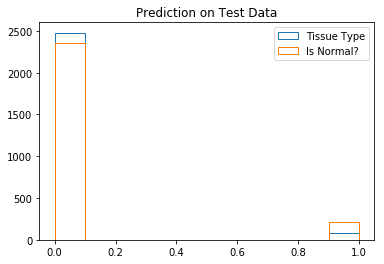

In [33]:
plt.hist(y_pred[:, 0], histtype='step', label = 'Tissue Type')
plt.hist(y_pred[:,1], histtype='step', label = 'Is Normal?')
plt.legend()
plt.title('Prediction on Test Data')
plt.show()

# GTEx Data

In [4]:
Gtex = pd.read_csv('data/GTEx_Expr_GOI.csv')
Gtex.head()

,Study_Abbr,Tissue_Type,TCGA_ID,Is_Normal,ENSG00000107796,ENSG00000119844,ENSG00000168283,ENSG00000039068,ENSG00000140937,ENSG00000170558,...,ENSG00000006327,ENSG00000140416,ENSG00000198467,ENSG00000167460,ENSG00000162692,ENSG00000038427,ENSG00000112715,ENSG00000150630,ENSG00000115935,ENSG00000114251
0,Adipose Tissue,M,SRR615237,True,76704.58000,8826.62100,8640.143000,227.917400,5946.573000,331.516300,...,2817.888000,94937.9700,81180.0500,121293.5000,2735.009000,38663.08000,107017.60000,1864.779000,18109.08000,310.796500
1,Adipose Tissue,M,SRR658081,True,837359.43830,11040.63138,10834.676900,353.064828,22890.369660,294.220690,...,3251.138621,230411.5776,221143.6259,224181.4545,8782.487586,63948.86690,33408.75931,6333.100345,25884.06517,316.287241
2,Adipose Tissue,M,SRR1090407,True,68842.49603,11080.92886,9164.869237,135.650239,6146.651431,101.737679,...,1322.589825,102475.2770,64374.5163,107740.2019,11445.488870,31759.11208,81212.10215,8588.355723,21576.86606,584.991653
3,Adipose Tissue,M,SRR813680,True,170189.04190,10835.63101,9891.337950,121.333746,8387.854581,100.232225,...,759.654754,112734.8757,105723.8954,101445.5620,2954.212934,29473.54940,54431.37332,6662.805243,19070.49957,316.522814
4,Adipose Tissue,M,SRR662103,True,666778.70090,12931.14812,15304.684250,816.866330,7690.873555,909.341763,...,2666.375000,287305.7594,357540.8512,208902.0043,3036.276734,38593.08092,78311.27962,4300.107659,18448.84899,107.888006


In [35]:
# Removing samples for which Tissue Type is unknown
filter_out = np.where(Gtex["Tissue_Type"].values != "E/M")

Gtex_filter = Gtex.iloc[filter_out]


pd.crosstab(index = Gtex_filter["Tissue_Type"], columns="count")

col_0,count
Tissue_Type,
E,532
M,972


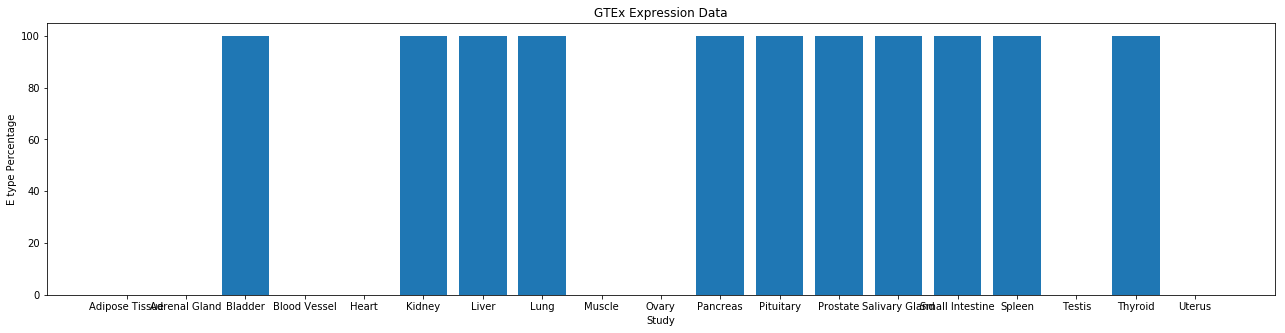

In [40]:
Gtex_filter_copy = Gtex_filter.copy()
Gtex_filter_copy["Tissue_Type"] = np.where(Gtex_filter["Tissue_Type"].str.contains("E"), 1, 0)
tissue_count = Gtex_filter_copy.pivot_table(columns='Study_Abbr', values='Tissue_Type', aggfunc='count')
tissue_normal = Gtex_filter_copy.pivot_table(columns='Study_Abbr', values='Tissue_Type', aggfunc= lambda x: sum(x))

percent_normal = tissue_normal.values.flatten()/tissue_count.values.flatten()*100.0

figure(figsize=(22, 5))
plt.bar(x = tissue_count.columns, height =  percent_normal)
plt.xlabel("Study")
plt.ylabel("E type Percentage")
plt.title("GTEx Expression Data")
plt.show()

In [38]:
Gtex_filter.head()

,Study_Abbr,Tissue_Type,TCGA_ID,Is_Normal,ENSG00000107796,ENSG00000119844,ENSG00000168283,ENSG00000039068,ENSG00000140937,ENSG00000170558,...,ENSG00000006327,ENSG00000140416,ENSG00000198467,ENSG00000167460,ENSG00000162692,ENSG00000038427,ENSG00000112715,ENSG00000150630,ENSG00000115935,ENSG00000114251
0,Adipose Tissue,M,SRR615237,True,76704.58000,8826.62100,8640.143000,227.917400,5946.573000,331.516300,...,2817.888000,94937.9700,81180.0500,121293.5000,2735.009000,38663.08000,107017.60000,1864.779000,18109.08000,310.796500
1,Adipose Tissue,M,SRR658081,True,837359.43830,11040.63138,10834.676900,353.064828,22890.369660,294.220690,...,3251.138621,230411.5776,221143.6259,224181.4545,8782.487586,63948.86690,33408.75931,6333.100345,25884.06517,316.287241
2,Adipose Tissue,M,SRR1090407,True,68842.49603,11080.92886,9164.869237,135.650239,6146.651431,101.737679,...,1322.589825,102475.2770,64374.5163,107740.2019,11445.488870,31759.11208,81212.10215,8588.355723,21576.86606,584.991653
3,Adipose Tissue,M,SRR813680,True,170189.04190,10835.63101,9891.337950,121.333746,8387.854581,100.232225,...,759.654754,112734.8757,105723.8954,101445.5620,2954.212934,29473.54940,54431.37332,6662.805243,19070.49957,316.522814
4,Adipose Tissue,M,SRR662103,True,666778.70090,12931.14812,15304.684250,816.866330,7690.873555,909.341763,...,2666.375000,287305.7594,357540.8512,208902.0043,3036.276734,38593.08092,78311.27962,4300.107659,18448.84899,107.888006


In [17]:
# Encoding E as 1 and M as 0
y = np.where(Gtex_filter["Tissue_Type"].str.contains("E"), 1, 0)
# Dropping "Is_Normal" since all the samples are normal
X = Gtex_filter.drop(columns = ["Study_Abbr", "Tissue_Type", "TCGA_ID", "Is_Normal"]).values

### Logistic Regression

In [18]:
params = {'model__penalty' : ['l1', 'l2'],
          'model__C' : [0.1, 1.0, 5.0],
         }
model_fitting_bin(X, y, LogisticRegression(class_weight = 'balanced'), params= params )

AUPRC score: 0.9997
AUROC score: 0.9998
Accuracy Score: 0.9920


,Predicted_0,Predicted_1
True_0,314,3
True_1,1,179


## Combining GTEx and TCGA

In [46]:
combined = pd.concat([tcga, Gtex_filter], axis = 0)
combined.shape

(9257, 253)

In [24]:
# Encoding E as 1 and M as 0
y = np.where(combined["Tissue_Type"].str.contains("E"), 1, 0)
# Dropping "Is_Normal"
X = combined.drop(columns = ["Study_Abbr", "Tissue_Type", "TCGA_ID", "Is_Normal"]).values

### Logistic Regression

In [25]:
params = {'model__penalty' : ['l1', 'l2'],
          'model__C' : [0.1, 1.0, 5.0],
         }
model_fitting_bin(X, y, LogisticRegression(class_weight = 'balanced'), params= params )

AUPRC score: 0.9995
AUROC score: 0.9970
Accuracy Score: 0.9885


,Predicted_0,Predicted_1
True_0,369,15
True_1,20,2651


### Multioutput classifier for prediction of tumor and tissue type

In [47]:
combined["Tissue_Type"] = data["Tissue_Type"].astype('category').cat.codes

y = np.asarray(list(zip(data["Tissue_Type"], data["Is_Normal"])))
X = data.drop(columns = ["Study_Abbr", "Tissue_Type", "TCGA_ID", "Is_Normal"]).values

In [48]:
params = {'model__estimator__max_depth':  [4,5,6],
          'model__estimator__learning_rate' : [0.01, 0.1, 0.2],
          'model__estimator__n_estimators' : [300, 500, 700]
}
model = MultiOutputClassifier(xgb.XGBClassifier(), n_jobs=-1)

clf = model_fitting_multi(X, y, model, params = params, score = 'f1_micro')

In [49]:
X_train, X_test, y_train, y_test = split_data(X, y)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average='micro')

0.9984399375975038

## Concatenating all : EMT, GTEx and TCGA

In [6]:
sample_data = pd.read_csv('data/sample_input.tsv', delimiter='\t')
Gtex = pd.read_csv('data/GTEx_Expr_GOI.csv')
tcga = pd.read_csv('data/TCGA_Expr_GOI.csv')
GOI_data = pd.concat([Gtex, tcga], axis = 0)
GOI_data.drop(columns = ["Study_Abbr", "Tissue_Type", "Is_Normal"], inplace=True)
sample_data.drop_duplicates(inplace = True)
GOI_data.drop_duplicates(inplace = True)

In [7]:
sample_cols = sample_data.columns
GOI_cols = GOI_data.columns
common_genes = set(sample_cols).intersection(set(GOI_cols))
GOI_data = GOI_data.drop(columns=common_genes)

In [8]:
# Trimming the ID's so that it matches with the sample data
GOI_data['TCGA_ID'] = GOI_data['TCGA_ID'].apply(lambda x: x[:16] if str(x).startswith('TCGA') else x )

In [9]:
GOI_data

,TCGA_ID,ENSG00000107796,ENSG00000119844,ENSG00000168283,ENSG00000039068,ENSG00000140937,ENSG00000170558,ENSG00000163624,ENSG00000108821,ENSG00000168542,...,ENSG00000164761,ENSG00000006327,ENSG00000140416,ENSG00000198467,ENSG00000167460,ENSG00000162692,ENSG00000038427,ENSG00000150630,ENSG00000115935,ENSG00000114251
0,SRR615237,76704.580000,8826.621000,8640.143000,227.917400,5946.573000,331.516300,269.357000,5.103279e+04,1.728443e+05,...,1056.708000,2817.888000,94937.97000,81180.050000,121293.50000,2735.009000,38663.080000,1864.779000,18109.080000,310.796500
1,SRR658081,837359.438300,11040.631380,10834.676900,353.064828,22890.369660,294.220690,1728.546552,5.092445e+05,4.575132e+05,...,1537.303103,3251.138621,230411.57760,221143.625900,224181.45450,8782.487586,63948.866900,6333.100345,25884.065170,316.287241
2,SRR1090407,68842.496030,11080.928860,9164.869237,135.650239,6146.651431,101.737679,449.341415,1.034757e+05,1.295629e+05,...,1246.286566,1322.589825,102475.27700,64374.516300,107740.20190,11445.488870,31759.112080,8588.355723,21576.866060,584.991653
3,SRR813680,170189.041900,10835.631010,9891.337950,121.333746,8387.854581,100.232225,654.147150,9.136431e+04,1.338786e+05,...,923.191542,759.654754,112734.87570,105723.895400,101445.56200,2954.212934,29473.549400,6662.805243,19070.499570,316.522814
4,SRR662103,666778.700900,12931.148120,15304.684250,816.866330,7690.873555,909.341763,1325.481214,8.191782e+04,1.067475e+05,...,693.565751,2666.375000,287305.75940,357540.851200,208902.00430,3036.276734,38593.080920,4300.107659,18448.848990,107.888006
5,SRR809987,366043.293000,10859.923180,11693.165360,268.489149,8341.680122,361.071615,629.560764,2.571663e+05,2.682855e+05,...,222.197917,1962.748264,163870.96350,225984.539500,154057.22220,10211.845920,20210.752170,13535.556420,29098.668840,6203.025174
6,SRR1101643,266460.688900,12844.065720,7369.235346,19695.497040,12162.079930,202.069864,5588.494671,9.604002e+04,6.936680e+04,...,429.398461,6567.270574,128225.95800,138449.430100,197567.49470,7722.857608,38847.931320,7577.619893,15969.833930,1117.698934
7,SRR613550,196736.649500,11125.580390,10069.486760,125.476471,7246.266176,125.476471,240.496569,1.065295e+05,1.336011e+05,...,846.966177,2363.140196,134082.06520,195983.790700,159365.57400,2540.898529,65007.268140,6796.642157,22146.597060,501.905882
8,SRR657599,183316.665000,11369.314720,9409.461421,1602.531980,9182.075127,660.503046,1342.661929,3.025212e+05,5.458679e+05,...,3399.966497,5186.573096,84533.56193,73662.331470,178931.35790,6236.881218,44405.294920,4547.725888,25034.148220,931.201015
9,SRR808566,53808.467450,9656.778382,10360.450610,860.875592,7568.219337,464.124232,606.355852,1.505634e+05,1.412585e+05,...,1444.773820,1976.270925,94307.04966,68855.075630,97346.31479,15697.879280,5681.778909,5382.343920,23857.482720,1976.270925


In [10]:
sample_data.set_index('sample_id', inplace=True)
GOI_data.set_index('TCGA_ID', inplace=True)

In [11]:
len(set(sample_data.index.values).intersection(set(GOI_data.index.values)))

8891

In [12]:
all_data = sample_data.join(GOI_data)

In [13]:
all_data

,Y,ENSG00000148926,ENSG00000109107,ENSG00000176171,ENSG00000104765,ENSG00000074410,ENSG00000107159,ENSG00000130635,ENSG00000047457,ENSG00000168209,...,ENSG00000164761,ENSG00000006327,ENSG00000140416,ENSG00000198467,ENSG00000167460,ENSG00000162692,ENSG00000038427,ENSG00000150630,ENSG00000115935,ENSG00000114251
SRR1068687,0,27928.727907,5837.087597,9251.701163,24059.383721,6349.693023,1025.210853,91218.962403,3.662648e+03,24894.434496,...,677.962016,992.139535,7.388380e+05,1.250212e+06,90466.589920,3960.290310,14716.736430,2992.954264,15179.734880,810.247287
SRR1068929,0,15018.120059,9790.760375,7071.690217,27000.999012,4331.541996,737.732213,72772.013340,5.796467e+02,33103.098320,...,105.390316,8673.623024,1.624265e+06,1.572993e+06,122558.398700,2297.508893,10328.250990,1433.308300,21752.561260,10349.329050
SRR1068953,0,6001.146979,5385.644725,8027.175233,12117.700631,3577.606853,126447.244364,18836.933574,3.846889e+02,22978.750827,...,102.583709,4898.372107,5.601071e+04,4.438028e+04,84118.641420,435.980763,7244.974451,743.731891,4526.506162,2154.257890
SRR1068977,0,11591.236184,9104.487976,9315.114190,42838.654244,18677.789138,95.121516,45631.150183,6.604151e+03,94217.861761,...,529.962733,2908.000637,1.767562e+05,8.950935e+04,114567.071800,4137.785953,48328.524610,3424.374582,16850.097150,5748.057334
SRR1068999,0,162589.372342,24325.810930,12339.070814,55773.199789,6679.290459,7.496398,115549.476015,2.766171e+03,175108.356704,...,3718.213319,74776.568270,2.736935e+04,3.799924e+04,194419.077500,5419.895625,51770.123350,3373.379020,13418.552100,532.244245
SRR1069048,0,23874.602125,11924.708973,10262.553129,26695.230224,93131.095632,1913.997639,22892.419126,7.278228e+03,20688.803424,...,125.920900,3991.692000,6.541591e+04,4.010581e+04,97236.120000,642.196600,37877.010000,2153.247000,9267.778000,1863.629000
SRR1069074,0,15439.580952,6450.088095,7480.360884,23152.115986,2401.551361,1073.805442,63100.580612,2.923943e+03,7001.501701,...,253.940476,1603.452721,1.335872e+06,1.216999e+06,75964.479590,2880.410544,8546.910884,3192.394558,14184.389460,4469.352381
SRR1069141,0,37633.486545,32834.585576,26853.180301,39091.525834,769.201830,183.689989,13294.562971,6.559340e+05,276063.092573,...,19218.565120,44820.357370,1.866750e+04,7.887189e+03,44039.674920,1951.706136,18977.472010,1653.209903,4959.629709,1963.186760
SRR1069166,0,15049.908090,6993.635451,9687.297162,28633.541610,5222.573470,856.699749,136709.509944,2.776037e+03,43189.199846,...,395.399884,3014.924117,6.300944e+05,6.764633e+05,74747.053100,626.049817,14077.883380,1688.687005,19053.331920,3047.874107
SRR1069188,0,1368.594268,310222.179332,14493.637654,17062.556403,3567.319485,5620.210886,5092.965554,2.759625e+03,31982.477518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Something fishy here!!!!!
len(all_data.index.values)

11096

In [21]:
from collections import Counter
count = Counter(all_data.index.values)
len(count.values())

11017

In [28]:
all_data.groupby(level=0).filter(lambda x: len(x) > 1)

,Y,ENSG00000148926,ENSG00000109107,ENSG00000176171,ENSG00000104765,ENSG00000074410,ENSG00000107159,ENSG00000130635,ENSG00000047457,ENSG00000168209,...,ENSG00000164761,ENSG00000006327,ENSG00000140416,ENSG00000198467,ENSG00000167460,ENSG00000162692,ENSG00000038427,ENSG00000150630,ENSG00000115935,ENSG00000114251
TCGA-06-0156-01A,1,25880.599898,73768.124841,18030.096971,65287.844362,15489.270298,4614.749300,10546.059430,6.061066e+04,20788.088318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-06-0156-01A,1,23941.256472,71709.876948,16191.271249,52213.075433,18270.470975,3962.398460,16959.383250,5.960284e+04,17799.009126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-21-1076-01A,1,13662.504541,4081.680424,7252.271468,35227.510656,8286.118155,485.274975,136302.807481,3.559962e+03,23224.147828,...,983.290710,7459.792048,35843.04915,23176.422380,198013.92170,1.393429e+04,65489.964980,1988.610337,33461.923580,22201.142190
TCGA-21-1076-01A,1,13662.504541,4081.680424,7252.271468,35227.510656,8286.118155,485.274975,136302.807481,3.559962e+03,23224.147828,...,1056.863681,6774.668825,35833.62485,24722.170580,203027.15750,1.615409e+04,70713.962500,1827.933010,39830.909630,18054.914400
TCGA-21-1076-01A,1,17537.019856,5068.653335,9900.996479,38005.888185,23530.887668,2399.149228,128572.770220,1.304112e+04,36289.635357,...,983.290710,7459.792048,35843.04915,23176.422380,198013.92170,1.393429e+04,65489.964980,1988.610337,33461.923580,22201.142190
TCGA-21-1076-01A,1,17537.019856,5068.653335,9900.996479,38005.888185,23530.887668,2399.149228,128572.770220,1.304112e+04,36289.635357,...,1056.863681,6774.668825,35833.62485,24722.170580,203027.15750,1.615409e+04,70713.962500,1827.933010,39830.909630,18054.914400
TCGA-44-2656-01A,1,2172.319033,1422.148118,13087.672375,47830.115585,591.339939,26.879088,32675.196976,1.770159e+05,15760.919869,...,891.897016,10382.658690,18832.46658,7975.758520,87425.45598,2.740934e+04,114759.045100,945.655192,17302.802110,8222.557420
TCGA-44-2656-01A,1,2172.319033,1422.148118,13087.672375,47830.115585,591.339939,26.879088,32675.196976,1.770159e+05,15760.919869,...,493.228792,30146.510270,18370.10022,14714.404470,106538.94620,1.449604e+04,41542.691320,1478.159353,24791.236670,5449.949102
TCGA-44-2656-01A,1,3186.899349,2237.090343,10650.993271,31123.805713,564.998926,48.864772,60169.331591,8.657311e+04,52433.427375,...,891.897016,10382.658690,18832.46658,7975.758520,87425.45598,2.740934e+04,114759.045100,945.655192,17302.802110,8222.557420
TCGA-44-2656-01A,1,3186.899349,2237.090343,10650.993271,31123.805713,564.998926,48.864772,60169.331591,8.657311e+04,52433.427375,...,493.228792,30146.510270,18370.10022,14714.404470,106538.94620,1.449604e+04,41542.691320,1478.159353,24791.236670,5449.949102


In [15]:
all_data.dropna(inplace=True)

all_data.shape

(8969, 279)

### Logistic Regression

In [16]:
y = all_data['Y'].values
X = all_data.drop(columns = ['Y']).values

In [18]:
params = {'model__penalty' : ['l1', 'l2'],
          'model__C' : [0.1, 1.0, 5.0],
         }
model_fitting_bin(X, y, LogisticRegression(class_weight = 'balanced'), params= params )

AUPRC score: 0.9979
AUROC score: 0.9932
Accuracy Score: 0.9780


,Predicted_0,Predicted_1
True_0,587,29
True_1,36,2308


## Summary

TCGA:
Classifying just the tissue type achieves good results with logistic regression
For predicting both tissue type and normality we convert this into a multi-class problem by taking combination of the two.

SVM fails to classify the highly imbalanced data but XGBoost works well though it takes an hour to train. Note we use F1 score to train for multiclass

GTEx:
All samples are normal so we only classify the tissue type. A simple logistic regressor gives remarkable results

Then, we add GTex and TCGA samples to predict tissue type


Finally, we combined all GTex, TCGA and EMT data to predict the presence of tumuor. Since, the data is not complete we only take genes in their intersection. More than one samples are taken from the same patient and we consider all of them for out training and testing. We find a simple logistic regression to work well in this case